In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
import time
from os import listdir
import sys

In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Dog_1_test_segment_0201.mat was damaged and was substituted by Dog_1_test_segment_0207.mat, but the name was left the same.

In [3]:
def my_simple_conv():
    
    model = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(2),
                      
                      nn.Conv2d(32, 64, 3, padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(2),
                      
                      Flatten(),
                      
                      nn.Linear(6400, 512),
                      nn.ReLU(),
                      nn.Linear(512, 2),
                      nn.Softmax(dim=1))
    return model

In [4]:
def monster_network():
    
    model = nn.Sequential(
                      nn.Conv2d(3, 32, 3, padding=1),
                      nn.BatchNorm2d(num_features=32),
                      nn.ReLU(),
                      nn.MaxPool2d(2),
                      
                      nn.Conv2d(32, 64, 3, padding=1),
                      nn.BatchNorm2d(num_features=64),
                      nn.ReLU(),
                      nn.MaxPool2d(2),
                      
                      nn.Conv2d(64, 128, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(128, 256, 3, padding=1),
                      nn.ReLU(),
                      nn.Conv2d(256, 512, 3),
                      nn.ReLU(),
                      
                      nn.Dropout(0.1),
        
                      Flatten(),
                      
                      nn.Linear(18432, 512),
                      nn.Dropout(0.1),
        
                      nn.Linear(512, 256),
                      nn.BatchNorm2d(num_features=256),
                      nn.ReLU(),
        
                      nn.Linear(256, 10),
                      nn.Softmax(dim=1))
    return model

In [5]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [6]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [9]:
# generate train and test data. EEG images are of the size num_electrodes x width

def get_data(width=100): 
    
    # read the first file:
    filename = listdir('./Dog_1/')[1]
    mat_file = loadmat('./Dog_1/'+filename)
    # get only data (not header and other garbage)
    #print(mat_file)
    segment = mat_file[list(mat_file.keys())[3]]
    segment = segment[0][0]
    # duration of a clip, should be 10mins = 600sec:
    duration = segment[1]
    # frequency of EEG (number of measurements per second):
    freq = segment[2]
    # number of electrodes:
    num_electrodes = segment[3].shape[1]
    # sequence: the index of the data segment within the one hour series of clips. 
    # For example, preictal_segment_6.mat has a sequence number of 6, 
    # and represents the iEEG data from 50 to 60 minutes into the preictal data.
    sequence = segment[4]
    # EEG data:
    eeg_data = np.array(segment[0], dtype=np.float)
    
    assert eeg_data.shape[0] == num_electrodes
    assert eeg_data.shape[1] == np.round(duration*freq)
    
    train_files = np.sum([filename.find('test') == -1 for filename in listdir('./Dog_1/')])
    test_files = np.sum([filename.find('test') != -1 for filename in listdir('./Dog_1/')])
    
    images_per_file = eeg_data.shape[1]//width
    train_size = train_files*images_per_file
    test_size = test_files*images_per_file
    
    X_train = np.zeros((train_size, 1, num_electrodes, width), dtype=np.int8)
    X_test = np.zeros((test_size, 1, num_electrodes, width), dtype=np.int8)
    y_train = np.zeros(train_size, dtype=np.int8)
    
    train_ind, test_ind = 0, 0
    
    for filename in listdir('./Dog_1/'):
        mat_file = loadmat('./Dog_1/'+filename)
        # get only data (not header and other garbage)
        keys = list(mat_file.keys())
        is_segment = [name.find('segment') != -1 for name in keys]
        key_index = is_segment.index(True)
        
        segment = mat_file[list(mat_file.keys())[key_index]]
        segment = segment[0][0]    
        
        # normalization:
        data = np.array(segment[0], dtype=np.float)
        img = data/np.max(data)
        img = img - np.mean(img)
        img = img/np.std(img)
        img = img.reshape((1,1,img.shape[0],img.shape[1]))
        
        # if train_data:
        if filename.find('test') == -1:
            
            for im in range(images_per_file):
                im_index = train_ind*images_per_file + im
                X_train[im_index, :, :] = img [:,:,:,width*im:width*(im+1)]
            if filename.find('preictal') != -1:
                y_train[train_ind*images_per_file:(train_ind+1)*images_per_file] = 1
            train_ind+=1    
        elif filename.find('test') != -1:
            for im in range(images_per_file):
                im_index = test_ind*images_per_file + im
                X_test[im_index, :, :] = img[:,:,:,width*im:width*(im+1)]
            test_ind+=1

    #print(sys.getsizeof(X_train)/1024/1024, 'Mb ', sys.getsizeof(X_test)/1024/1024, 'Mb')
        
    return X_train, X_test, y_train

In [11]:
X_train, X_test, y_train = get_data()

In [14]:
y_train = np.array(y_train, dtype=np.int32)

In [15]:
np.random.seed(42)
idx_train = np.random.permutation(y_train.shape[0])
X_train, y_train = X_train[idx_train], y_train[idx_train]

In [16]:
X_train, y_train = X_train[:-20*2400], y_train[:-20*2400]
X_val, y_val = X_train[-20*2400:], y_train[-20*2400:]

__ Training __

In [95]:
model = my_simple_conv()

In [96]:
opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

In [97]:
num_epochs = 1 # total amount of full passes over training data
batch_size = 80  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        
        X_batch = np.array(X_batch, dtype=np.int32)
        #print(X_batch.shape)
        
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        X_batch = np.array(X_batch, dtype=np.int32)
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))
        
      
    #torch.save(model.state_dict(), './models/m_'+str(epoch))
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 1 took 3186.990s
  training loss (in-iteration): 	0.355204
  validation accuracy: 			95.82 %


__ Testing __

In [ ]:
accuracy = []

for epoch in range(50):
    
    start_time = time.time()
    
    model = monster_network()
    model.load_state_dict(torch.load('./models/m_'+str(epoch)))
    
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        test_batch_acc.append(np.mean(y_batch == y_pred))
        
    test_accuracy = np.mean(test_batch_acc)
    print('Time to evaluate model #',epoch,' is ', time.time() - start_time, ', accuracy = ', test_accuracy)
    
    
    accuracy.append(test_accuracy)
    
    
test_accuracy = np.max(accuracy)
ep_best = np.argmax(accuracy == test_accuracy)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'18. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

### example of a vizualized dataset element:

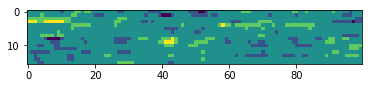

In [98]:
plt.imshow(X_train[0, :, :])

### Draft for future work:

In [8]:
x = loadmat('./Dog_1/Dog_1_preictal_segment_0006.mat')

In [20]:
a = list(x.keys())

In [170]:
c= [b.find('segment')==-1 for b in a]

In [171]:
c

[True, False, True, True]

In [172]:
c.index(True)

0

In [75]:
a[0][0][0]

array([[  8,   2,  -1, ...,  -9, -20, -30],
       [  6,  -7,  -6, ..., -19, -18, -16],
       [-22, -29, -30, ...,  -5,   3,  10],
       ...,
       [-36, -14,  -5, ...,   7,   8,  11],
       [  9,  14,  14, ...,  10,  17,  13],
       [ 23,  22,  12, ..., -14, -10,  -8]], dtype=int16)

In [6]:
x = loadmat('./Dog_1/Dog_1_interictal_segment_0007.mat')

In [9]:
a = x['preictal_segment_6']

In [10]:
a

array([[(array([[-23, -20, -28, ..., -15, -16, -29],
       [ 13,  12,   4, ..., -14, -15, -25],
       [ 76,  75,  82, ...,  16,  21,  23],
       ...,
       [-36, -35, -37, ...,  -5,  -1,  11],
       [-19, -17, -15, ...,  -6,  -1,   1],
       [ -1,  -1,  -2, ..., -11,  -1,   5]], dtype=int16), array([[600]], dtype=uint16), array([[399.6097561]]), array([[array(['NVC1202_32_002_Ecog_c001'], dtype='<U24'),
        array(['NVC1202_32_002_Ecog_c002'], dtype='<U24'),
        array(['NVC1202_32_002_Ecog_c003'], dtype='<U24'),
        array(['NVC1202_32_002_Ecog_c004'], dtype='<U24'),
        array(['NVC1202_32_002_Ecog_c005'], dtype='<U24'),
        array(['NVC1202_32_002_Ecog_c006'], dtype='<U24'),
        array(['NVC1202_32_002_Ecog_c007'], dtype='<U24'),
        array(['NVC1202_32_002_Ecog_c008'], dtype='<U24'),
        array(['NVC1202_32_002_Ecog_c009'], dtype='<U24'),
        array(['NVC1202_32_002_Ecog_c010'], dtype='<U24'),
        array(['NVC1202_32_002_Ecog_c011'], dtype='<U24'

In [13]:
sys.getsizeof(a)

112

In [73]:
X_train[45]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

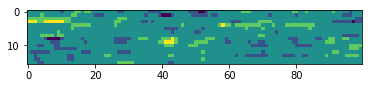

In [88]:
plt.imshow(X_train[0, :, 0:100])

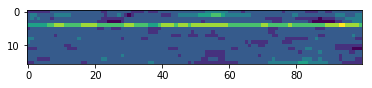

In [99]:
plt.imshow(X_train[20, :, :])

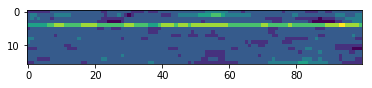

In [89]:
plt.imshow(X_train[0, :, 20*100:2100])